# Import modules

In [1]:
from IPython.display import clear_output

import os
import glob
from pathlib import Path
import time
import copy

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

from torch.utils.data import random_split
from torch.utils.data.dataset import Dataset

from torchvision import datasets, transforms, models
from torchvision.datasets.utils import download_url, extract_archive
from torchvision.utils import make_grid

import torchmetrics

import pytorch_lightning as pl
from tqdm.notebook import tqdm as _tqdm2
from pytorch_lightning.callbacks.early_stopping import EarlyStopping as EarlyStoppingPL
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint

# Download dataset

In [2]:
root = './'
filename = 'data.zip'
archive = os.path.join(root, filename)
url = 'https://sid.erda.dk/share_redirect/heaAFNnmaG/data.zip'
data_folder = os.path.join(root, 'data/images')
force_download = False
if (not os.path.exists(data_folder) or force_download):
    download_url(url, root, filename)
    extract_archive(archive, './data', False)

# Get image folder metrics

In [3]:
widths = []
heights = []

for filename in glob.iglob(data_folder + '/**/*.jpg', recursive=True):
    im = Image.open(filename)
    widths.append(im.size[0])
    heights.append(im.size[1])

widths = np.array(widths)
heights = np.array(heights)
avg_height = round(heights.mean())
avg_width = round(widths.mean())
min_height = heights.min()
min_width = widths.min()
max_height = heights.max()
max_width = widths.max()

print(avg_height, avg_width)
print(min_height, min_width)
print(max_height, max_width)

201 399
65 141
740 1568


# Import dataset

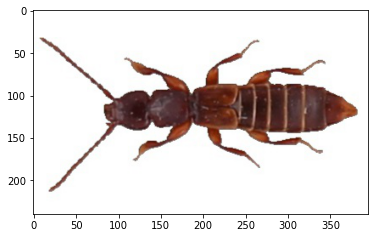

In [4]:
dataset = datasets.ImageFolder(data_folder)
image, label = dataset[5]
plt.imshow(image)

# Split dataset into train, validation and test sets

In [5]:
train_len = int(0.8 * len(dataset))
val_len = int(0.1 * len(dataset))
test_len = len(dataset) - (train_len + val_len)
dataset_lengths = [train_len, val_len, test_len]
dataset_sizes = {'train': train_len, 'val': val_len, 'test': test_len}
train_data, val_data, test_data = random_split(dataset, dataset_lengths)

# Apply augmentations

In [6]:
class TransformsDataset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)

In [7]:
img_height = round(224/0.95) #or 256
img_width = img_height
img_height_crop = 224
img_width_crop = img_height_crop
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

resize = transforms.Resize((img_height, img_width))
resize_default = transforms.Resize((img_height_crop, img_width_crop))
center_crop = transforms.CenterCrop((img_height_crop, img_width_crop))
normalize = transforms.Normalize(imagenet_mean, imagenet_std)
tensorfy = transforms.ToTensor()


rotate = transforms.RandomRotation((-3, 3))
random_crop = transforms.RandomCrop((img_height_crop, img_width_crop))
vertical_flip = transforms.RandomVerticalFlip(0.5)

default_transforms = transforms.Compose(
    [resize_default, tensorfy, normalize]
)
test_transforms = transforms.Compose(
    [resize, center_crop, tensorfy, normalize]
)
train_transforms = transforms.Compose([
    resize, rotate, random_crop,
    vertical_flip, tensorfy, normalize]
)

val_data_T = TransformsDataset(val_data, test_transforms)
test_data_T = TransformsDataset(test_data, test_transforms)
train_data_T = TransformsDataset(train_data, train_transforms)

# Initialize data-loaders

In [8]:
# number of threads to handle data. bug makes ipynb hang when num > 0.
num_workers = 0
# larger size induces faster convergence (usually) but be wary, your GPU might run out of memory. 
# Also smaller sizes induces learning which generalize better.
batch_size = 16

train_loader = torch.utils.data.DataLoader(train_data_T, batch_size=batch_size,
                                            num_workers=num_workers, shuffle = True)
val_loader = torch.utils.data.DataLoader(val_data_T, batch_size=batch_size,
                                         num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data_T, batch_size=batch_size,
                                          num_workers=num_workers)
data_loaders = {'train': train_loader, 'val': val_loader, 'test': test_loader}


In [9]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

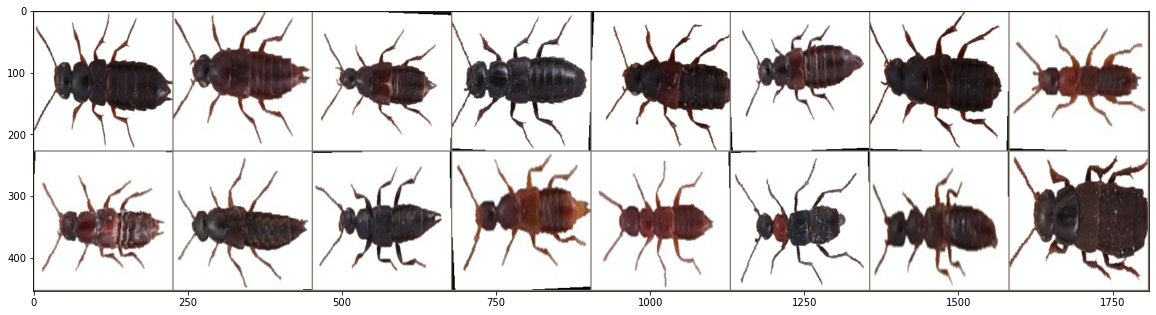

In [10]:
iterable = iter(train_loader)
images, labels = next(iterable)
img_grid = make_grid(images, nrow = 8)
plt.figure(figsize = (20,20))
imshow(img_grid)

# Define the classification model

In [11]:
# start by setting up device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# now use resnet18 pretrained with last layer replaced
#model = models.resnet18(pretrained=True)
# consider using resnet50 instead
model = models.resnet50(pretrained=True)
num_fc = model.fc.in_features

# were just counting the number of classes by counting subfolders in image folder
num_classes = len(next(os.walk(data_folder))[1])
model.fc = nn.Linear(num_fc, num_classes)
# used for later
model_copy = copy.deepcopy(model)
model = model.to(device)

# what kind of objective will we be using for our classification?
# we are dealing with multiclass classification so cross entropy loss makes sense
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized (i.e. all layers are unfrozen)

# using ADAM (usually better than SGD but seems to diverge in this case)
optimizer = optim.Adam(model.parameters(), lr = 0.001, eps = 0.1)
# using stochastic gradient descent (default)
#optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs (experiment with this)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


# Early stopping class

In [12]:
class EarlyStopping():
    """
    Early stopping to stop the training when the loss does not improve after
    certain epochs.
    """

    def __init__(self, patience=5, min_delta=0):
        """
        :param patience: how many epochs to wait before stopping when loss is
               not improving
        :param min_delta: minimum difference between new loss and old loss for
               new loss to be considered as an improvement
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            print(
                f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True

# Define model trainer

In [14]:
def train_model(model, data_loaders, dataset_sizes, criterion, 
                optimizer, early_stopping, scheduler = None,
                num_epochs=100, device="cuda:0"):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_loss, train_acc = [], []
    val_loss, val_acc = [], []
    epochs = []

    for epoch in range(num_epochs):
        epochs.append(epoch)
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in data_loaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = (running_corrects.double()).item() / dataset_sizes[phase]
            if phase == 'train':
                if scheduler != None:
                    scheduler.step()
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
            else:
                val_loss.append(epoch_loss)
                val_acc.append(epoch_acc)
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                early_stopping(epoch_loss)
        clear_output(wait=True)
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                'Train', train_loss[-1], train_acc[-1]))
        print('{} Loss: {:.4f} Acc: {:.4f}'.format(
            'Val', val_loss[-1], val_acc[-1]))
        print()
        if early_stopping.early_stop:
            break       
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    # load best model weights
    model.load_state_dict(best_model_wts)
    metrics = np.array([epochs, train_loss, train_acc, 
                        val_loss, val_acc]).T
    return model, metrics

# Load and or train model

In [15]:
Path("models").mkdir(parents=True, exist_ok=True)
load_model = True
train_model = False
if load_model == True:
    model.load_state_dict(torch.load('models/model_0_parameters.pt'))
    metrics = np.load('models/model_0_metrics.npy')
if train_model == True:
    model, metrics = train_model(model, data_loaders, dataset_sizes,criterion, 
                                optimizer,  EarlyStopping(), device = device)

# Test the model

In [16]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on test images: %.2f %%' %
      (100 * correct / total))

C:\Users\Jacki\anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Accuracy of the network on test images: 95.04 %


# Save trained model and metrics

In [17]:
Path("models").mkdir(parents=True, exist_ok=True)
torch.save(model.state_dict(), 'models/model_0_parameters.pt')
torch.save(model, 'models/model_0.pt')
np.save('models/model_0_metrics', metrics)

# plot metrics

In [18]:
def multiplot(systems, x_axis, y_axis, labels, name, title=None, dpi=200):
    plt.figure()
    plt.xlabel(x_axis)
    plt.ylabel(y_axis)
    for i in range(len(systems)):
        plt.plot(systems[i, 0], systems[i, 1], label=labels[i])
        plt.title(title, pad = 20)
    plt.legend()
    plt.grid()
    plt.savefig('figures/'+name,  bbox_inches='tight', facecolor='w', dpi=dpi)
    plt.show()
    plt.close()

In [19]:
epochs = metrics[:,0]
remaining_metrics = metrics[:,1:]
systems = np.array([[epochs, metric] for metric in remaining_metrics.T])
systems.shape
if not os.path.exists('figures'):
    os.makedirs('figures')

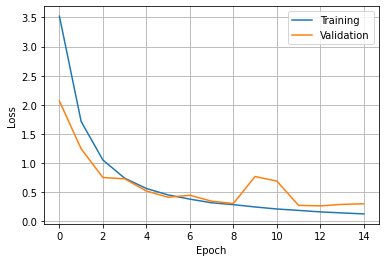

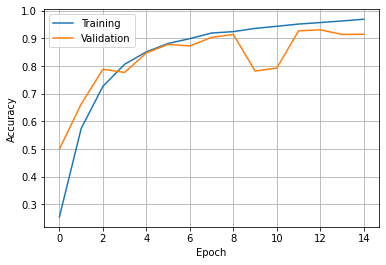

In [20]:
labels = ['Training', 'Validation']
name = 'loss_comparison.pdf'
multiplot(systems[[0,2]], 'Epoch', 'Loss', labels, name)
labels = ['Training', 'Validation']
name = 'accuracy_comparison.pdf'
multiplot(systems[[1, 3]], 'Epoch', 'Accuracy', labels, name)

# Training and testing with PyTorch Lightning

In [ ]:
## pytorch lightning uses tqdm.auto for progress bars.
## this implementation is currently not working with notebooks so we
## need to monkey patch the tqdm class in the pl library to use tqdm.notebook
# instead of tqdm.auto
_PAD_SIZE = 5


class tqdm2(_tqdm2):
    """
    Custom tqdm progressbar where we append 0 to floating points/strings to prevent the progress bar from flickering
    """
    @staticmethod
    def format_num(n) -> str:
        """Add additional padding to the formatted numbers"""
        should_be_padded = isinstance(n, (float, str))
        if not isinstance(n, str):
            n = _tqdm2.format_num(n)
        if should_be_padded and "e" not in n:
            if "." not in n and len(n) < _PAD_SIZE:
                try:
                    _ = float(n)
                except ValueError:
                    return n
                n += "."
            n += "0" * (_PAD_SIZE - len(n))
        return n


pl.callbacks.progress.tqdm = tqdm2

In [ ]:
class PLWrapper(pl.LightningModule):
    def __init__(self, model, optimizer, criterion, dataset_sizes):
        super().__init__()
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.accuracy = torchmetrics.Accuracy()
        self.dataset_sizes = dataset_sizes

        self.running = np.zeros(4)
        self.train_losses = []
        self.train_accs = []
        self.val_losses = []
        self.val_accs = []

    def configure_optimizers(self):
        return self.optimizer

    def forward(self,x):
        return self.model(x)

    def step(self, batch, phase):
        images, labels = batch
        outputs = self.model(images)
        _, preds = torch.max(outputs, 1)
        loss = self.criterion(outputs, labels)
        acc = self.accuracy(preds, labels)
        if phase == 'train':
            idx1, idx2 = 0, 1
        else:
            idx1, idx2 = 2, 3
        self.running[idx1] += loss.item() * images.size(0)
        self.running[idx2] += acc.item() * images.size(0)
        self.log(phase + '_loss', loss)
        self.log(phase + '_acc', acc)
        return loss
    
    def epoch_end(self, outputs, phase):
        if phase == 'train':
            idx1, idx2 = 0, 1
            losses, accs = self.train_losses, self.train_accs
        else:
            idx1, idx2 = 2, 3
            losses, accs = self.val_losses, self.val_accs

        avg_loss = self.running[idx1]/dataset_sizes[phase]
        avg_acc = self.running[idx2]/dataset_sizes[phase]
        losses.append(avg_loss)
        accs.append(avg_acc)
        self.running[[idx1, idx2]] = 0

    def training_step(self,batch, batch_idx):
        return self.step(batch, 'train')

    def validation_step(self, batch, batch_idx):
        return self.step(batch, 'val')

    def test_step(self, batch, batch_idx):
        return self.step(batch, 'test')

    def training_epoch_end(self, outputs):
        self.epoch_end(outputs, 'train')
    
    def validation_epoch_end(self, outputs):
        self.epoch_end(outputs, 'val')

    def on_train_end(self):
        epochs = np.arange(len(self.train_losses))
        self.metrics = np.array([epochs, self.train_losses, self.train_accs, 
                                    self.val_losses, self.val_accs]).T

In [ ]:
#optimizer = optim.Adam(model_copy.parameters(), lr=0.001, eps=0.1)
#pl_model = PLWrapper(model, optimizer, criterion, dataset_sizes)
#early_stopping_pl = EarlyStoppingPL(monitor='val_loss')
#checkpoint = ModelCheckpoint(monitor='val_loss', every_n_epochs=1)
#trainer = pl.Trainer(gpus=-1, callbacks=[checkpoint, early_stopping_pl],
#                     default_root_dir='data', max_epochs=100, num_sanity_val_steps = 0)

In [ ]:
#trainer.fit(pl_model, train_loader, val_loader)

In [ ]:
#test_result = trainer.test(pl_model, test_loader)